<a href="https://colab.research.google.com/github/rohanjadhav41193/MachineLearningPart2/blob/ml2projects/GarbageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt
from google.colab import drive
import pathlib
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow.keras.applications.xception import preprocess_input
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import Xception
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
drive.mount('/content/drive',force_remount=True)
data_dir = 'drive/My Drive/ColabNotebooks/GarbageDataset/Garbageclassification/'
os.listdir(data_dir)  # shows the subfolders I had shared with me

Mounted at /content/drive


['trash76.jpg',
 'trash',
 'plastic',
 'metal',
 'glass',
 'paper',
 'cardboard',
 'zero-indexed-files.txt',
 'one-indexed-files-notrash_train.txt',
 'one-indexed-files.txt',
 'one-indexed-files-notrash_val.txt',
 'one-indexed-files-notrash_test.txt']

In [11]:
# some variables to easily navigate
INPUT = '/kaggle/input/garbage-classification/'
GLASS = data_dir + '/glass/'
PAPER = data_dir + '/paper/'
CARDBOARD = data_dir + '/cardboard/'
PLASTIC = data_dir + '/plastic/'
METAL = data_dir + '/metal/'
TRASH = data_dir + '/trash/'
MATERIALS = [GLASS,
             PAPER,
             CARDBOARD,
             PLASTIC,
             METAL,
             TRASH]

In [12]:
def load_csv(subset):
    
    if subset == 'train':
        fname = data_dir + 'one-indexed-files-notrash_train.txt'
    elif subset == 'validation':
        fname = data_dir + 'one-indexed-files-notrash_val.txt'
    elif subset == 'test':
        fname = data_dir + 'one-indexed-files-notrash_test.txt'
    else:
        raise ValueError('subset must be "train", "validation" or "test"')
    
    df = pd.read_csv(fname, sep=' ', names=['file', 'label'])
    
    # change the labels to be from 0 to 5
    df['label'] -= 1
    
    # create path column
    df['folder'] = [MATERIALS[i] for i in df['label']]
    df['path'] = df['folder'] + df['file']
    
    # change type of label for datagenerator
    df['label_str'] = df['label'].astype(str)
    
    return df

In [13]:
# Read all the csv files
df_train = load_csv('train')
df_valid = load_csv('validation')
df_test = load_csv('test')

df_train.head()

,file,label,folder,path,label_str
0,cardboard202.jpg,2,drive/My Drive/ColabNotebooks/GarbageDataset/G...,drive/My Drive/ColabNotebooks/GarbageDataset/G...,2
1,paper472.jpg,1,drive/My Drive/ColabNotebooks/GarbageDataset/G...,drive/My Drive/ColabNotebooks/GarbageDataset/G...,1
2,paper522.jpg,1,drive/My Drive/ColabNotebooks/GarbageDataset/G...,drive/My Drive/ColabNotebooks/GarbageDataset/G...,1
3,glass189.jpg,0,drive/My Drive/ColabNotebooks/GarbageDataset/G...,drive/My Drive/ColabNotebooks/GarbageDataset/G...,0
4,glass325.jpg,0,drive/My Drive/ColabNotebooks/GarbageDataset/G...,drive/My Drive/ColabNotebooks/GarbageDataset/G...,0


In [14]:
IMG_SIZE = 299
classes = ['glass', 'paper', 'cardboard', 'plastic', 'metal', 'trash']

In [17]:
# for the train set
datagen_aug = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.1,
    zoom_range=0.2,
    preprocessing_function=preprocess_input,
    rotation_range=90)

train_datagen = datagen_aug.flow_from_dataframe(
    df_train,
    x_col='path',
    y_col='label_str',
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=True)

# for the validation and test sets
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

valid_datagen = datagen.flow_from_dataframe(
    df_valid,
    x_col='path',
    y_col='label_str',
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=False)

test_datagen = datagen.flow_from_dataframe(
    df_test,
    x_col='path',
    y_col='label_str',
    class_mode='sparse',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    shuffle=False)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1767 validated image filenames belonging to 6 classes.
Found 328 validated image filenames belonging to 6 classes.
Found 431 validated image filenames belonging to 6 classes.


Text(0, 0.5, 'population')

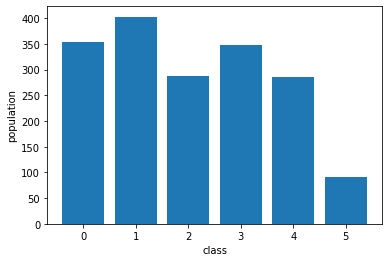

In [23]:
plt.hist(df_train['label'], bins=np.arange(7)-0.5, rwidth=0.8)
plt.xlabel('class')
plt.ylabel('population')

Text(0, 0.5, 'Class weight')

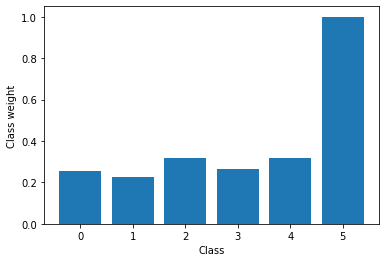

In [19]:
hist, _ = np.histogram(df_train['label'], bins=np.arange(7)-0.5)
class_weight = hist.min()/hist
class_weight = {i:class_weight[i] for i in range(6)}

plt.bar(np.arange(6), [class_weight[i] for i in range(6)])
plt.xlabel('Class')
plt.ylabel('Class weight')

In [24]:
def cnn_model():
    
    X_input = L.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # load pretrained model and freeze the weights
    pretrained = Xception(include_top=False, weights='imagenet')
    pretrained.trainable = False
    X = pretrained(X_input, training=False)
    
    # last layers
    X = L.GlobalAveragePooling2D()(X)
    X = L.Dense(1024, activation='relu')(X)
    X = L.Dense(512, activation='relu')(X)
    X = L.Dense(6, activation='softmax')(X)
    
    # create model
    model = Model(inputs=X_input, outputs=X)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    
    return model

In [29]:
model = cnn_model()
model.summary()


83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 3078      
Total params: 23,487,534
Trainable params: 2,626,054
Non-train

In [30]:
callbacks = [EarlyStopping(
                monitor='val_loss',
                patience=10,
                restore_best_weights=True)]

history = model.fit(
    train_datagen,
    epochs=100,
    class_weight=class_weight,
    callbacks=callbacks,
    validation_data=valid_datagen)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
56/56 [==============================] - 1368s 24s/step - loss: 0.2515 - acc: 0.7165 - val_loss: 0.4317 - val_acc: 0.8445
Epoch 2/100
56/56 [==============================] - 711s 13s/step - loss: 0.1480 - acc: 0.8229 - val_loss: 0.4131 - val_acc: 0.8628
Epoch 3/100
56/56 [==============================] - 722s 13s/step - loss: 0.1234 - acc: 0.8596 - val_loss: 0.3316 - val_acc: 0.8720
Epoch 4/100
56/56 [==============================] - 730s 13s/step - loss: 0.1110 - acc: 0.8710 - val_loss: 0.3721 - val_acc: 0.8689
Epoch 5/100
56/56 [==============================] - 720s 13s/step - loss: 0.0977 - acc: 0.8857 - val_loss: 0.3223 - val_acc: 0.8902
Epoch 6/100
56/56 [==============================] - 728s 13s/step - loss: 0.0882 - acc: 0.8959 - val_loss: 0.3268 - val_acc: 0.8780
Epoch 7/100
56/56 [==============================] - 724s 13s/s

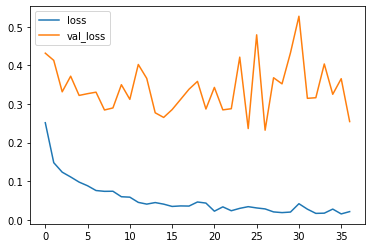

In [31]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

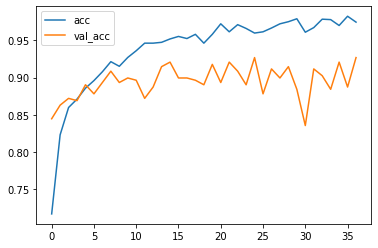

In [32]:
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()

In [33]:
def plot_cm(y_true, y_pred, title, classes):
    '''
    Fancy confusion matrix plot.
    '''
    y_pred = y_pred.astype(int)
    
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    cm = pd.DataFrame(cm, index=classes, columns=classes)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    
    fig, ax = plt.subplots()
    plt.title(title)
    sns.heatmap(cm, cmap='viridis', annot=annot, fmt='', ax=ax)

In [36]:
pred_valid = np.argmax(model.predict(valid_datagen), axis=1)
pred_test = np.argmax(model.predict(test_datagen), axis=1)

score_valid = f1_score(df_valid['label'], pred_valid, average='macro')
score_test = f1_score(df_test['label'], pred_test, average='macro')

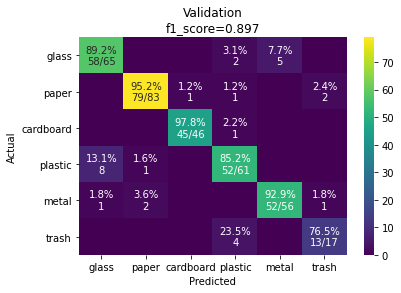

In [41]:
plot_cm(df_valid['label'], pred_valid, 'Validation\nf1_score=' + str('%.3f' %score_valid), classes)

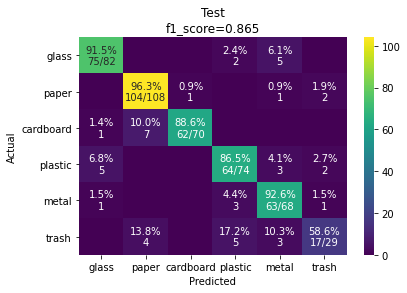

In [42]:
plot_cm(df_test['label'], pred_test, 'Test\nf1_score=' + str('%.3f' %score_test), classes)